# Goal


1. 用部分数据（10k/label）train 一个 model，
2. 用这个 model 预测其他数据，取 accuracy > 95% 且与标注相同的数据作为新的 labeled data
3. 用新的 labeled data 作为新的训练数据，重复 1-2 步。



# 训练细节

1. 同 baseline 模型相同的方法，train model
2. 从 test 中取 248 张图片做 inference， 选出新的 labeled 的 data。
    - 以 >95% accuracy 作为 good data。111 张选出，比例 48%，人工验证，全部标注正确.
    - 以 90% accuracy 作为阈值，选出较多错误标注。
1. 以全部 3000 个 test image 做 inference，1022 个选出，比例 34%，抽查 30 张，2 张 sexy 的标注错误。


# 结论


1. 用训练的模型 inference 原始数据集，可以帮助选出 30% 质量极高的 ground truth data。
2. 过滤条件 prediction accuracy > 95%, 且预测与已有标注相同。

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

tf.__version__

'2.1.0'

# Load Datasets

In [2]:
DATA_DIR = '/home/jackon/datasets/porn_hot_images/resized-256x256'
# classes = ['drawings', 'hentai', 'neutral', 'porn', 'sexy']
labels = ['neutral', 'porn', 'sexy']

In [3]:
def read_label_images(label):
    filepath = os.path.join(DATA_DIR, label)
    files = os.listdir(filepath)
    df1 = pd.DataFrame([os.path.join(DATA_DIR, label, f) for f in files])
    df1['label'] = label
    df1.columns = ['file', 'label']
    return df1

# df = read_label_images('sexy')
# df.head()

In [4]:
from PIL import Image


def preview_images(df, nrow=5, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 20))
    for i, img_idx in enumerate(range(min(len(df), nrow * ncol))):
        item = df.iloc[i]
        image_obj = Image.open(item['file'])
        w, h = image_obj.size
        ax = axes.flat[i]
        ax.imshow(image_obj)
#         ax.set_title('pred: {}'.format(
#             ''.join(map(lambda i: b[i], y_pred[img_idx].numpy()))))
        ax.set_xlabel('true: {}. size: {} * {}'.format(item['label'], w, h))
        ax.set_xticks([])
        ax.set_yticks([])
# preview_images(df)

In [5]:
# read all images
from sklearn.utils import shuffle

MAX_COUNT_PER_LABEL = 10000

images = [read_label_images(label) for label in labels]

df = shuffle(pd.concat(i[:MAX_COUNT_PER_LABEL] for i in images))
df_rest = shuffle(pd.concat(i[MAX_COUNT_PER_LABEL:] for i in images))
df.head()

file label
3853  /home/jackon/datasets/porn_hot_images/resized-...  porn
2242  /home/jackon/datasets/porn_hot_images/resized-...  porn
7872  /home/jackon/datasets/porn_hot_images/resized-...  porn
7523  /home/jackon/datasets/porn_hot_images/resized-...  sexy
8244  /home/jackon/datasets/porn_hot_images/resized-...  sexy

In [6]:
p = np.arange(len(df))

RATIO = 1

total = int(len(df) * RATIO)
train_up_to = int(total * 0.6)
valid_idx_to = int(total * 0.9)

train_idx = p[:train_up_to]
valid_idx = p[train_up_to:valid_idx_to]
test_idx = p[valid_idx_to:total]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 18000, valid count: 9000, test count: 3000


In [7]:
df[:total]['label'].value_counts()

neutral    10000
sexy       10000
porn       10000
Name: label, dtype: int64

In [8]:
df_rest['label'].value_counts()

porn       47158
neutral    26202
sexy        4882
Name: label, dtype: int64

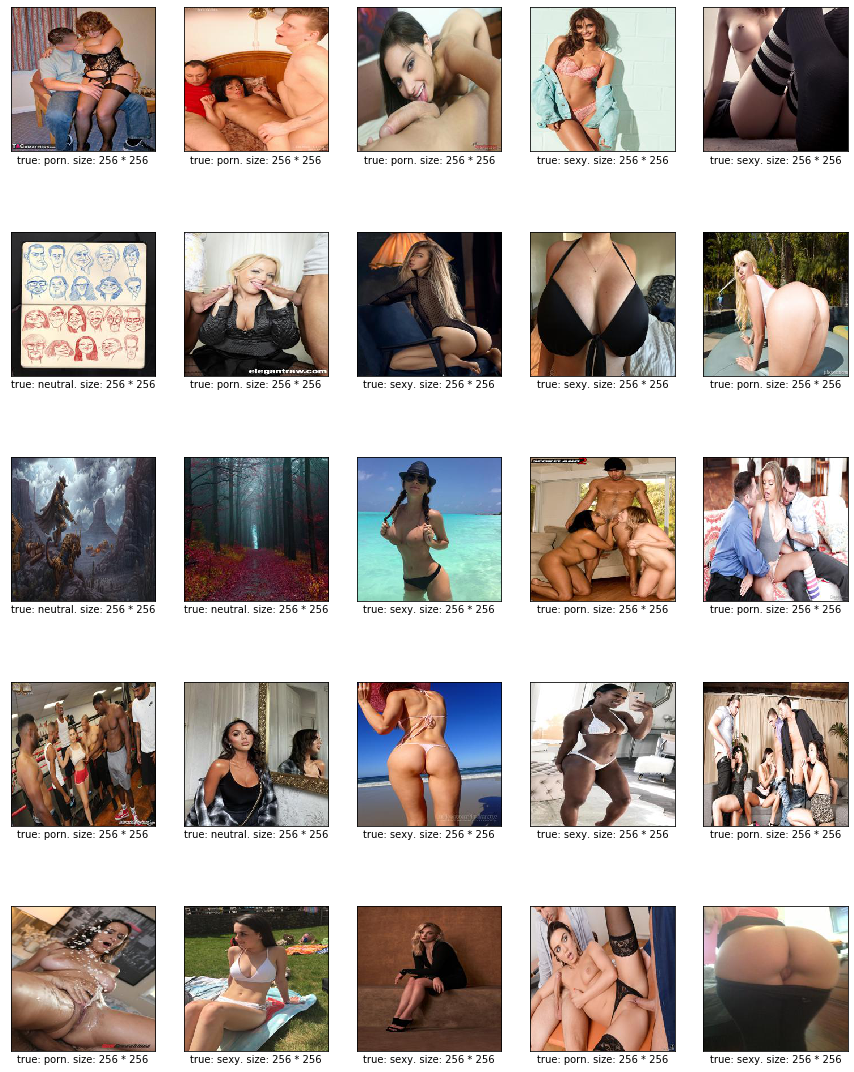

In [9]:
preview_images(df)

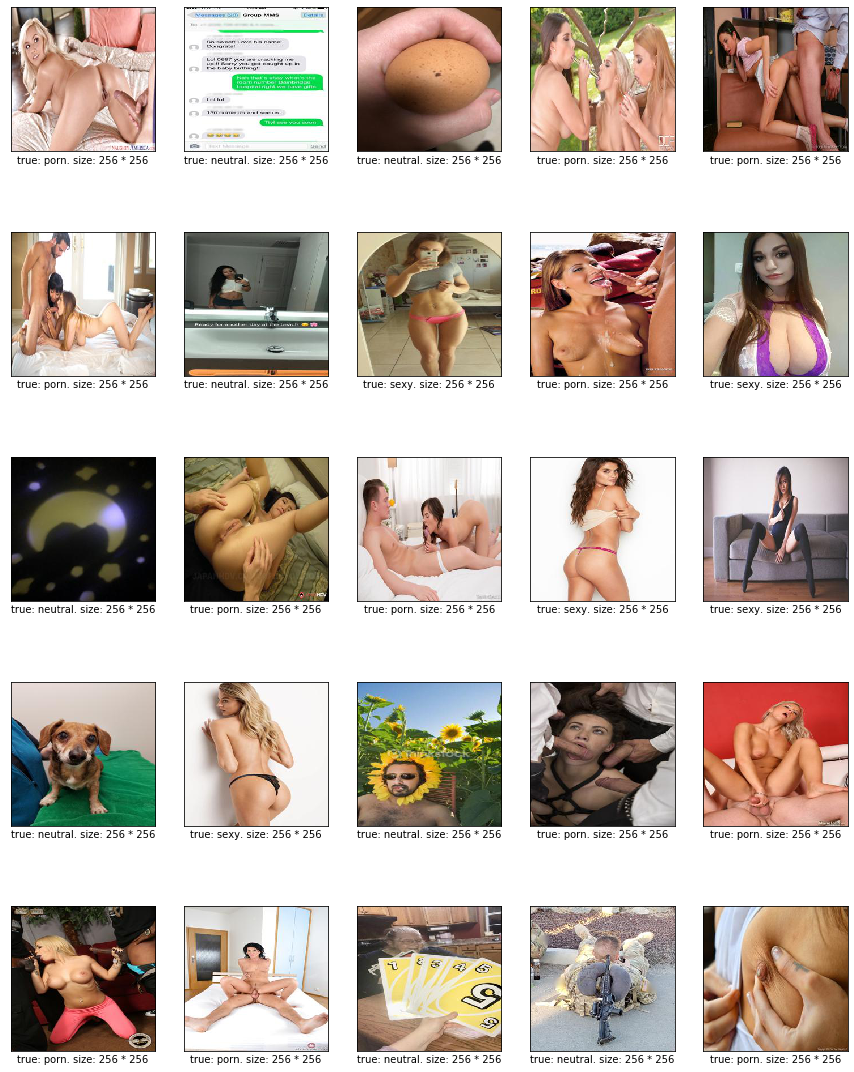

In [10]:
preview_images(df_rest)

# label mapping

In [11]:
label2idx = {
    label: idx for idx, label in enumerate(labels)
}
label2idx

{'neutral': 0, 'porn': 1, 'sexy': 2}

In [12]:
idx2label = {
    idx: label for label, idx in label2idx.items()
}
idx2label

{0: 'neutral', 1: 'porn', 2: 'sexy'}

In [13]:
W, H, C = 256, 256, 3  # resized to 256x256 pixels
N_LABELS = len(labels)

In [14]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            try:
                im = Image.open(file)
                if im.mode != 'RGB':
                    im = im.convert('RGB')
            except Exception as e:
                print('error image: %s' % file)
                print(e)
                continue

            im = im.resize((H, W))
            im = np.array(im) / 255.0
            if len(im.shape) != 3:
                print(im.shape)
                continue
            images.append(np.array(im))
            labels.append(np.array(
                to_categorical(label2idx[label], N_LABELS)
            ))
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [15]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model


def conv_block(input_data, filters=32, bn=True, pool=True, kernel_size=3, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation)(input_data)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(N_LABELS, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0     

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 140 steps
Epoch 1/5
280/281 [============================>.] - ETA: 0s - loss: 0.9842 - accuracy: 0.5707WARNING:tensorflow:From /home/jackon/venv-py3-tf/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
281/281 [==============================] - 69s 247ms/step - loss: 0.9838 - accuracy: 0.5708 - val_loss: 0.7761 - val_accuracy: 0.6519
Epoch 2/5
281/281 [==============================] - 62s 222ms/step - loss: 0.6432 - accuracy: 0.7194 - val_loss: 0.6506 - val_accuracy: 0.7240
Epoch 3/5
281/281 [==============================] - 63s 224ms/step - loss: 0.5306 - accuracy: 0.

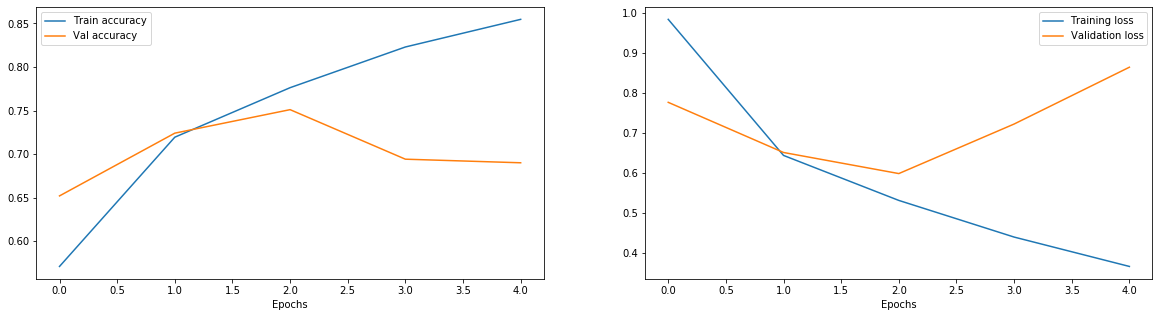

In [17]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [18]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

  ...
    to  
  ['...']
23/23 [==============================] - 7s 302ms/step - loss: 0.8829 - accuracy: 0.6861


{'loss': 0.8828519453173098, 'accuracy': 0.6861413}

In [19]:
good_data = []
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=248)
for x_test, y_test in test_gen:
    y_pred_onehot = model.predict_on_batch(x_test)

    y_true = tf.math.argmax(y_test, axis=-1)
    y_pred = tf.math.argmax(y_pred_onehot, axis=-1)

    for img_idx, _ in enumerate(y_pred):
        pred_id = y_pred[img_idx].numpy()
        prob = y_pred_onehot[img_idx].numpy()[pred_id]

        pred = idx2label[pred_id]
        ground_truth = idx2label[y_true[img_idx].numpy()]
    
        if pred == ground_truth and prob > 0.95:
            good_data.append((y_pred[img_idx], y_pred_onehot[img_idx], y_true[img_idx], x_test[img_idx]))
len(good_data)

1022

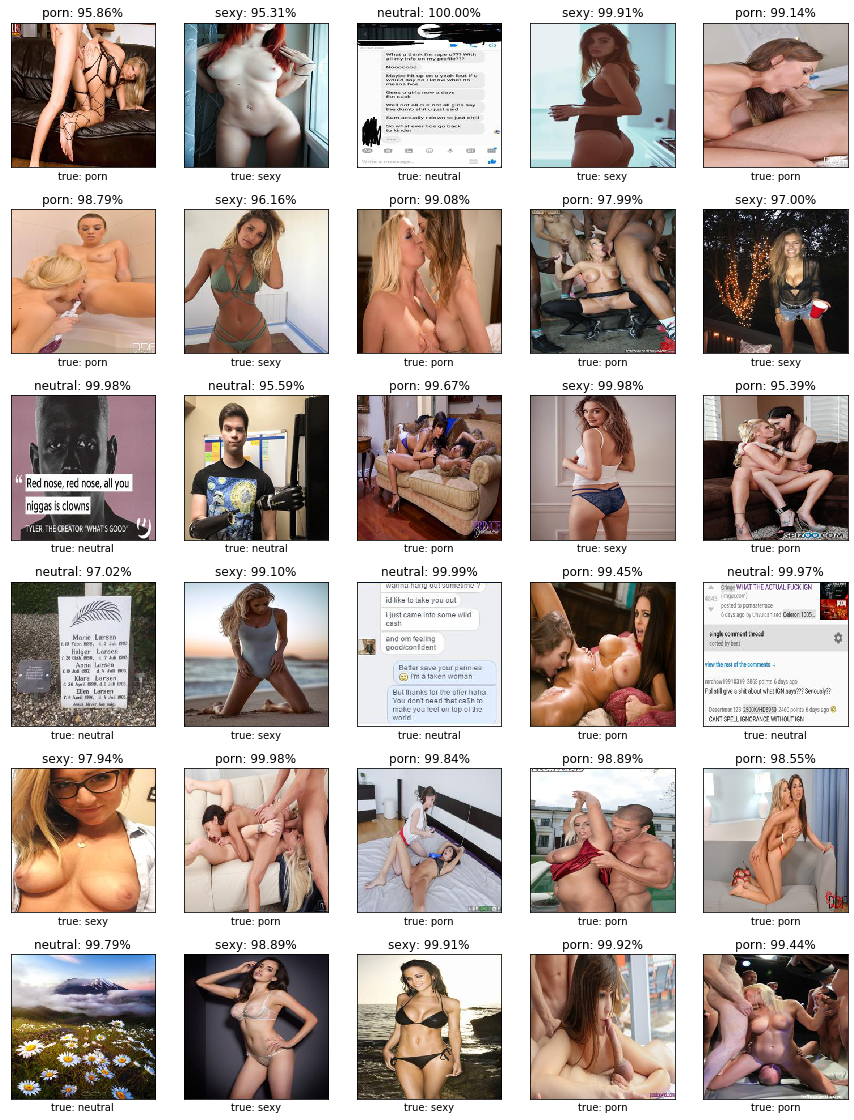

In [20]:
import math

start = 0
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, (i_pred, i_pred_onehot, i_true, i_image) in enumerate(good_data[start: start + n]):
    ax = axes.flat[i]
    ax.imshow(i_image)

    pred_id = i_pred.numpy()
    prob = i_pred_onehot.numpy()[pred_id]
    pred = idx2label[pred_id]

    ground_truth = idx2label[i_true.numpy()]
    ax.set_title('%s: %.2f%%' % (pred, prob * 100))
    ax.set_xlabel('true: %s' % ground_truth)
    ax.set_xticks([])
    ax.set_yticks([])